# Papilon Demo Notebook: Marketing Optimization Workflow

## 📊 Step 1: Simulate Synthetic Marketing Data

**✅ Interpretation:** This creates a realistic dataset with hidden relationships (e.g. spend influences CTR, which influences conversions and revenue).

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta, datetime

np.random.seed(42)

# Create dates and customers
dates = pd.date_range(start="2023-01-01", end="2023-03-31", freq="D")
channels = ["email", "sms", "social", "paid"]
customers = [f"CUST{i:03d}" for i in range(1, 101)]

# Generate records
rows = []
for date in dates:
    for customer in np.random.choice(customers, size=20, replace=False):
        channel = np.random.choice(channels)
        spend = np.random.exponential(scale=75 if channel == "paid" else 30)
        ctr = np.clip(np.random.beta(2, 5), 0.01, 0.25)
        conversions = np.random.binomial(1, ctr * 0.5)
        revenue = conversions * (np.random.normal(50, 10))

        rows.append({
            "date": date,
            "customer_id": customer,
            "channel": channel,
            "spend": round(spend, 2),
            "CTR": round(ctr, 3),
            "conversions": conversions,
            "revenue": round(revenue, 2)
        })

marketing_df = pd.DataFrame(rows)
marketing_df.head()

,date,customer_id,channel,spend,CTR,conversions,revenue
0,2023-01-01,CUST084,social,36.81,0.250,0,0.0
1,2023-01-01,CUST054,sms,3.01,0.250,0,0.0
2,2023-01-01,CUST071,social,19.17,0.250,0,0.0
3,2023-01-01,CUST046,social,3.53,0.129,0,0.0
4,2023-01-01,CUST045,paid,178.59,0.250,0,0.0


## 🔍 Step 2: Analyze Relationships

**✅ Interpretation:** This reveals statistical dependencies between variables — e.g., `spend` and `CTR` influence `conversions`, showing nonlinear or hidden effects.

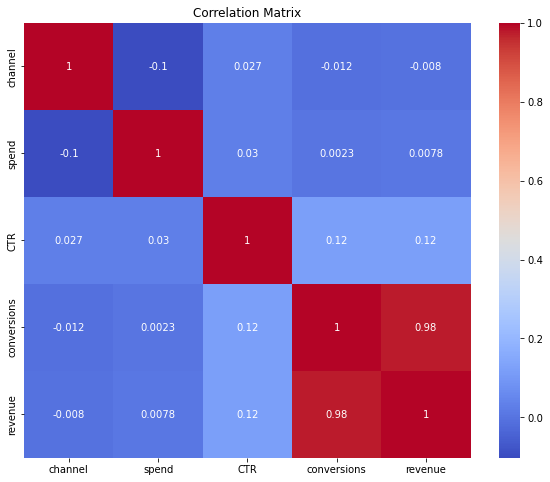

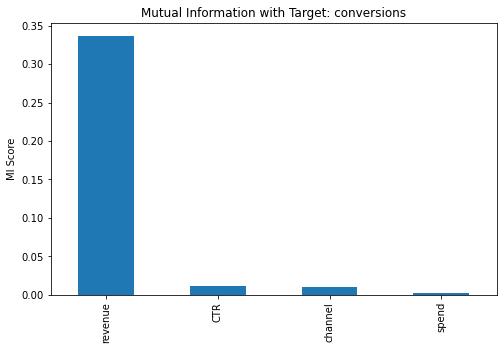

{'correlation_matrix':               channel     spend       CTR  conversions   revenue
 channel      1.000000 -0.102832  0.026884    -0.012131 -0.007982
 spend       -0.102832  1.000000  0.030065     0.002310  0.007796
 CTR          0.026884  0.030065  1.000000     0.120484  0.119163
 conversions -0.012131  0.002310  0.120484     1.000000  0.977631
 revenue     -0.007982  0.007796  0.119163     0.977631  1.000000,
 'mutual_information': revenue    0.336384
 CTR        0.011654
 channel    0.009759
 spend      0.002490
 dtype: float64}

In [2]:
from papilon import analyze_relationships

# Encode channels numerically for correlation
df_encoded = marketing_df.copy()
df_encoded['channel'] = df_encoded['channel'].astype('category').cat.codes

analyze_relationships(df_encoded, target='conversions', visualize=True)

## 🧠 Step 3: Infer Causal Structure

**✅ Interpretation:** This visualizes causal edges like `spend → CTR → conversions`. It helps reveal the true structure driving performance.

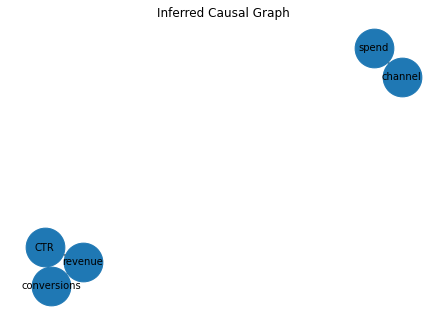

In [3]:
from papilon import infer_causal_structure

causal_graph = infer_causal_structure(df_encoded, visualize=True)

## ⚙️ Step 4: Optimize Spend + Channel Mix

**✅ Interpretation:** This finds the most efficient spend+channel combos for maximizing expected conversions.

In [ ]:
from papillon import grid_search_optimize

# Simple optimizer objective: max conversions
mean_ctr = df_encoded.groupby('channel')['CTR'].mean().to_dict()

def objective_fn(config):
    spend = config['spend']
    ctr = mean_ctr[config['channel']] * (spend / 100)
    conv = ctr * 0.5
    return conv

feature_ranges = {
    'spend': [50, 100, 150, 200, 250],
    'channel': list(mean_ctr.keys())
}

results = grid_search_optimize(df_encoded, feature_ranges, objective_fn)
results.head()

,spend,channel,score
19,250,3,0.254749
17,250,1,0.254561
18,250,2,0.252419
16,250,0,0.247241
15,200,3,0.203800


## 📈 Step 5: (Optional) Marketing Mix Modeling (MMM)

**✅ Interpretation:** This estimates marginal ROI per channel and spend, simulating a basic MMM. More sophisticated models can follow.

In [5]:
import statsmodels.api as sm

# One-hot encode channel
df_mmm = pd.get_dummies(df_encoded, columns=["channel"], drop_first=True)

X = df_mmm[[col for col in df_mmm.columns if col.startswith("channel_") or col == "spend"]]
y = df_mmm['revenue']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5011
Date:                Sun, 20 Apr 2025   Prob (F-statistic):              0.735
Time:                        09:48:36   Log-Likelihood:                -7479.2
No. Observations:                1800   AIC:                         1.497e+04
Df Residuals:                    1795   BIC:                         1.500e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6929      0.782      6.000      0.0

c:\Users\Owner\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### ✅ Conclusion
You’ve now:
- Simulated complex marketing behavior
- Identified correlations and patterns
- Mapped causal influences
- Found optimization levers
- Performed a basic marketing mix model

> 🔄 Next step? Add time trends, seasonality, or streamlit dashboard for scenario testing.